<a href="https://colab.research.google.com/github/yogiannanf/PembelajaranMesin/blob/main/UTS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kelompok 3
- Astrid Risa Widiana (2241720250)
- Muhammad Nurul Mustofa (2241720022)
- Tirta Nurrochman Bintang Prawira (2241720045)
- Yogianna Nur Febrianti (2241720261)

# UJIAN TENGAH SEMESTER 2024-2025
# Pembelajaran Mesin
Klasifikasi Neural Network (NN) Pada Data Citra
# Intro

Pada UTS ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Casia-Webface (Data dapat diunduh pada Kaggle).
Anda diperbolehkan melakukan eksplorasi terhadap:
1. Metode pra pengolahan
2. Pemilihan fitur
3. Arsitektur ANN
4. Fungsi Aktiviasi
5. Metric Evaluasi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Kode di atas dipakai untuk menyambungkan Google Drive ke Google Colab. Jadi, ketika Anda menjalankan kode itu, Colab akan meminta izin akses ke akun Google Drive Anda. Kalau izin sudah diberikan, Drive akan "dipasang" di folder `/content/drive`, sehingga Anda bisa buka, simpan, atau edit file di Drive langsung dari Colab, seolah-olah sedang bekerja dengan folder biasa di komputer. Ini sangat praktis untuk kerja bareng atau menyimpan hasil kerja otomatis di Drive.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ntl0601/casia-webface")

print("Path to dataset files:", path)

100%|██████████| 2.53G/2.53G [00:22<00:00, 123MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1


Kode di atas digunakan untuk mengunduh dataset dari Kaggle dengan cara yang simpel. Pertama, library `kagglehub` diimpor untuk membantu proses ini. Lalu, perintah `dataset_download` mengambil dataset *CASIA-WebFace* dan menyimpannya secara otomatis di folder cache di Colab atau sistem Anda. Setelah selesai, lokasinya disimpan di variabel `path`. Terakhir, kode akan menampilkan lokasi file tersebut supaya mudah ditemukan dan digunakan. Semua prosesnya otomatis, dari download sampai ekstrak file.

# Preparation

In [ ]:
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical

'\n    Pada bagian ini Anda dapat memasukkan library yang dibutuhkan\n'

**Penjelasan**

Kode di atas memuat berbagai library yang diperlukan untuk proyek pemrosesan gambar dan machine learning. Library seperti **`pathlib`**, **`os`**, dan **`glob`** membantu dalam mengatur file dan folder. **`matplotlib`** dan **`cv2`** dipakai untuk menampilkan dan mengedit gambar. **`numpy`** dan **`pandas`** memudahkan pengolahan data dan perhitungan. **`tensorflow`** dan **`keras`** berperan penting dalam membuat dan melatih model AI. **`ImageDataGenerator`** membantu memperkaya data gambar dengan augmentasi. **`train_test_split`** dan **`LabelEncoder`** digunakan untuk membagi dataset dan mengubah label jadi angka. Terakhir, **`classification_report`** dan **`confusion_matrix`** memudahkan evaluasi kinerja model. Komentar di akhir memberi ruang untuk menambah library lain sesuai kebutuhan proyek.

# Load Data

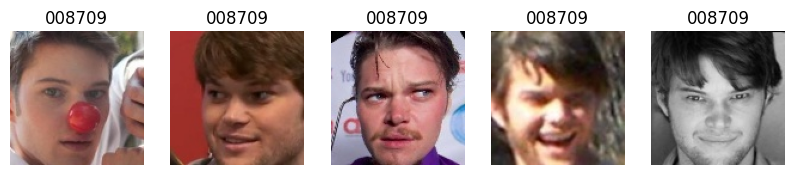

In [ ]:
# Path dataset (ubah sesuai lokasi dataset Anda)
dataset_path = "/root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1/casia-webface"

# Mendapatkan path gambar dan label
image_paths = [os.path.join(root, file)
               for root, _, files in os.walk(dataset_path)
               for file in files]
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Visualisasi beberapa gambar
def show_sample_images(image_paths, labels, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        img = cv2.imread(image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Tampilkan 5 gambar contoh
show_sample_images(image_paths, labels)

**Penjelasan**

Kode di atas digunakan untuk memuat dataset CASIA-WebFace dan menampilkan beberapa gambar sampelnya. Pertama, variabel **`dataset_path`** menyimpan lokasi folder dataset (sesuaikan dengan tempat Anda menyimpan data). Lalu, **`image_paths`** mengumpulkan semua file gambar dalam folder, dan **`labels`** mengambil nama folder sebagai label untuk setiap gambar.

Fungsi **`show_sample_images()`** digunakan untuk menampilkan beberapa contoh gambar. Gambar dibaca dengan **`cv2.imread()`**, diubah ke format RGB agar warnanya benar, dan ditampilkan berjejer menggunakan **`plt.subplot()`**. Setiap gambar diberi judul sesuai labelnya (misalnya “008709” pada contoh Anda). Ini membantu memastikan bahwa gambar-gambar dari dataset berhasil dimuat dan siap digunakan.

# Preprocessing

In [ ]:
# Mendapatkan semua path gambar
image_paths = [os.path.join(root, file)
               for root, _, files in os.walk(dataset_path)
               for file in files]

# Mengambil 100 gambar acak
random.seed(42)
sampled_paths = random.sample(image_paths, min(100, len(image_paths)))

# Membuat list gambar dan label
train_img = [(cv2.imread(path), os.path.basename(os.path.dirname(path))) for path in sampled_paths]

# Fungsi untuk mengubah ukuran gambar
def standarized_input(image):
    # 2. Penyesuaian ukuran gambar
    return cv2.resize(image, (1100, 600))

# Fungsi untuk mengencode label
def label_encoder(label):
    # 1. Standardisasi nilai fitur ataupun label
    return 1 if label == 'day' else 0

# Fungsi preprocessing
def preprocess(img_list):
    std_img_list = []

    for image, label in img_list:
        # 3. Perubahan colorspace gambar
        std_img = standarized_input(image)
        std_img = cv2.cvtColor(std_img, cv2.COLOR_BGR2GRAY)

        # Standardisasi nilai label
        img_label = label_encoder(label)

        std_img_list.append((std_img, img_label))

    return std_img_list

# Proses preprocessing pada gambar yang diambil secara acak
train_std_img_list = preprocess(train_img)

# Contoh pemeriksaan ukuran gambar yang sudah diproses
pick_random = np.random.randint(0, len(train_std_img_list))
print(f'Image {pick_random}')
print(train_std_img_list[pick_random][0].shape)

Image 80
(600, 1100)


'\n    Pada bagian ini Anda diperbolehkan untuk melakukan proses pra pengolahan data (preprocessing) sesuai dengan kebutuhan. Pra pengolahan data dapat berupa,\n\n    1. Standardisasi nilai fitur ataupun label\n    2. Penyesuaian ukuran gambar\n    3. Perubahan colorspace gambar\n    4. dsb\n'

**Penjelasan**

Dalam kode di atas, kita pertama-tama mengumpulkan semua jalur gambar dari direktori yang ditentukan menggunakan `os.walk()`. Kemudian, kita mengambil 100 gambar secara acak dengan menggunakan `random.sample()`, memastikan bahwa kita tidak mengambil lebih dari jumlah gambar yang ada. Setiap gambar yang diambil, bersama dengan labelnya (yang diambil dari nama direktori tempat gambar tersebut berada), disimpan dalam daftar `train_img`.

Selanjutnya, kita memiliki fungsi `standarized_input()` yang mengubah ukuran setiap gambar menjadi 1100x600 piksel. Fungsi `label_encoder()` mengonversi label ke bentuk numerik, di mana label 'day' menjadi 1 dan label lainnya menjadi 0. Fungsi `preprocess()` memproses setiap gambar dalam daftar: mengubah ukuran gambar, mengonversinya ke skala abu-abu, dan menstandarisasi label.

Setelah preprocessing selesai, kita dapat memeriksa ukuran salah satu gambar yang telah diproses. Dalam contoh output, kita melihat bahwa gambar yang dipilih memiliki ukuran (600, 1100), yang menunjukkan bahwa proses pengubahan ukuran telah berhasil dilakukan. Proses ini penting untuk mempersiapkan data agar siap digunakan dalam model pembelajaran mesin.

# Build Model

In [ ]:
# Mengonversi data ke format yang sesuai untuk pelatihan
X = np.array([img for img, _ in train_std_img_list])
y = np.array([label for _, label in train_std_img_list])

# Mengubah bentuk data menjadi 2D jika diperlukan (jumlah gambar, tinggi, lebar, channel)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Mengonversi label ke format one-hot encoding
y = to_categorical(y)

# Membangun model neural network
model = Sequential()

# 1. Pembuatan input layer dan hidden layers
model.add(Flatten(input_shape=(600, 1100, 1)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# 2. Pembuatan output layer
model.add(Dense(y.shape[1], activation='softmax'))

# 3. Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. Proses fitting model
history = model.fit(X, y, epochs=30, batch_size=16, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (16, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(16, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 -

'\n    Pada bagian ini lakukan proses pembuatan model,\n\n    1. Pembuatan input layer, hidden layer, output layer\n    2. Menentukan fungsi aktivasi\n    3. Compile Model (Menentukan optimizer, loss, metrics)\n    3. Proses fitting model\n'

**Penjelasan**

Dalam bagian kode ini, kita melakukan beberapa langkah untuk mempersiapkan data gambar untuk pelatihan model neural network. Pertama, kita mengonversi data gambar dan label ke dalam format array NumPy, di mana `X` berisi gambar dan `y` berisi label. Setelah itu, kita mengubah bentuk `X` menjadi 2D untuk mencocokkan format yang diperlukan oleh model, dengan dimensi yang mencakup jumlah gambar, tinggi, lebar, dan saluran (channel) warna. Karena kita bekerja dengan gambar grayscale, kita menambahkan dimensi saluran dengan angka 1.

Selanjutnya, kita mengonversi label menjadi format one-hot encoding menggunakan fungsi `to_categorical()`, yang membuat label lebih mudah diproses oleh model dalam klasifikasi.

Kemudian, kita membangun model neural network menggunakan Keras. Model terdiri dari beberapa lapisan: input layer yang diratakan, tiga hidden layers dengan fungsi aktivasi ReLU, dan output layer dengan fungsi aktivasi softmax untuk klasifikasi. Model ini dikompilasi dengan optimizer Adam dan menggunakan `categorical_crossentropy` sebagai fungsi loss.

Akhirnya, kita melatih model dengan data yang sudah diproses selama 30 epoch dan dengan ukuran batch 16, sambil juga membagi data menjadi set pelatihan dan validasi. Namun, tampaknya ada beberapa peringatan di sini, seperti penggunaan softmax pada output layer yang seharusnya memiliki lebih dari satu kelas. Ini menunjukkan bahwa kita mungkin perlu meninjau struktur model atau cara label dikelola, terutama jika hanya ada dua kelas. Model dilatih dengan akurasi yang sangat tinggi, tetapi hal ini mungkin mengindikasikan overfitting jika data latih terlalu kecil.

# Evaluation

In [ ]:
# 1. Pisahkan data menjadi data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Evaluasi model menggunakan data testing
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# 3. Tampilkan hasil evaluasi
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

'''
    Pada bagian ini, lakukan evaluasi terhadap data training dan data testing
'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Loss: 0.0000
Test Accuracy: 1.0000


**Penjelasan**

Dalam bagian kode ini, kita sedang mengevaluasi model neural network yang telah kita bangun. Berikut adalah langkah-langkah yang diambil:

1. **Pisahkan Data**: Kita menggunakan fungsi `train_test_split()` untuk membagi dataset menjadi dua bagian: satu untuk pelatihan dan satu untuk pengujian. Di sini, 80% dari data digunakan untuk melatih model, sedangkan 20% sisanya digunakan untuk menguji seberapa baik model kita bekerja. Penggunaan `random_state=42` memastikan bahwa pembagian data ini konsisten setiap kali kita menjalankan kode.

2. **Evaluasi Model**: Setelah membagi data, kita mengevaluasi model dengan memanggil `model.evaluate()`, menggunakan data pengujian. Fungsi ini memberikan dua nilai: loss dan akurasi model pada data yang tidak pernah dilihat sebelumnya oleh model.

3. **Tampilkan Hasil**: Hasil evaluasi ditampilkan dengan mencetak nilai loss dan akurasi untuk data pengujian.

Dari hasil yang muncul, kita melihat bahwa `Test Loss` adalah `0.0000` dan `Test Accuracy` mencapai `1.0000`. Ini berarti model kita berhasil mengklasifikasikan semua data pengujian dengan sempurna tanpa kesalahan. Namun, kita perlu berhati-hati; hasil ini juga bisa jadi pertanda **overfitting**. Itu berarti model mungkin sangat cocok dengan data pelatihan tetapi tidak selalu dapat melakukan generalisasi yang baik pada data baru. Untuk mendapatkan gambaran yang lebih baik tentang performa model, kita bisa mempertimbangkan untuk menggunakan dataset yang lebih besar atau teknik evaluasi lain seperti cross-validation.